# A. 시계열 분석 소개
- **시계열 분석**: 시간 순서로 정렬된 데이터에서 의미 있는 정보를 추출하는 과정
- 시계열 분석의 목적은 사람들이 더 나은 의사결정을 내릴 수 있도록 돕는 것이다.
- 좋은 예측은 좋은 의사결정을 촉진한다.
- 경제학자, 통계학자, 분석가, 데이터과학자 등 다양한 전문가들이 시계열 분석을 이용한다. 
- 시계열 분석은 금융, 전통 산업, 전자 산업, 컨설팅, 정부, 중앙은행 및 국제 기구 등 다양한 분야에 사용된다. 
- 예측(Forecast)은 의사결정을 안내하는 역할을 한다.

### 예측이 쉬워지기 위한 조건들
1. 영향을 줄 수 있는 요인들에 대한 깊은 이해가 필요하다.
2. 가용할 수 있는 데이터가 많아야 한다.
3. 미래의 양상이 과거와 유사해야한다.
4. 예측이 실제 미래에 영향을 주지 않아야 한다.


### 예측 (Forecast)란?
가능한 미래의 확률과 가능성에 대한 추정이다.



다음은 호주에 방문한 방문객의 수에 대한 시계열 데이터를 2010년까지 시각화하고, 미래 시점에 대한 예측까지 시각화한 코드이다. 그래프를 통해 미래 시점에서의 방문객의 수를 예측할 수 있다.


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
austa = pd.read_excel("C:/Users/ksooy/Desktop/timeseries_data/340101.xlsx", sheet_name="Data1", skiprows=9)
austa.rename(columns={'A85232561W': 'Visitors'}, inplace=True)
austa.rename(columns={'Series ID': 'Month'}, inplace=True)

austa_filtered = austa[(austa['Month'] >= '2000-01-01') & (austa['Month'] <= '2010-12-31')]

actual_post_2010 = austa[(austa['Month'] > '2010-12-31')& (austa['Month'] <= '2016-12-31')]

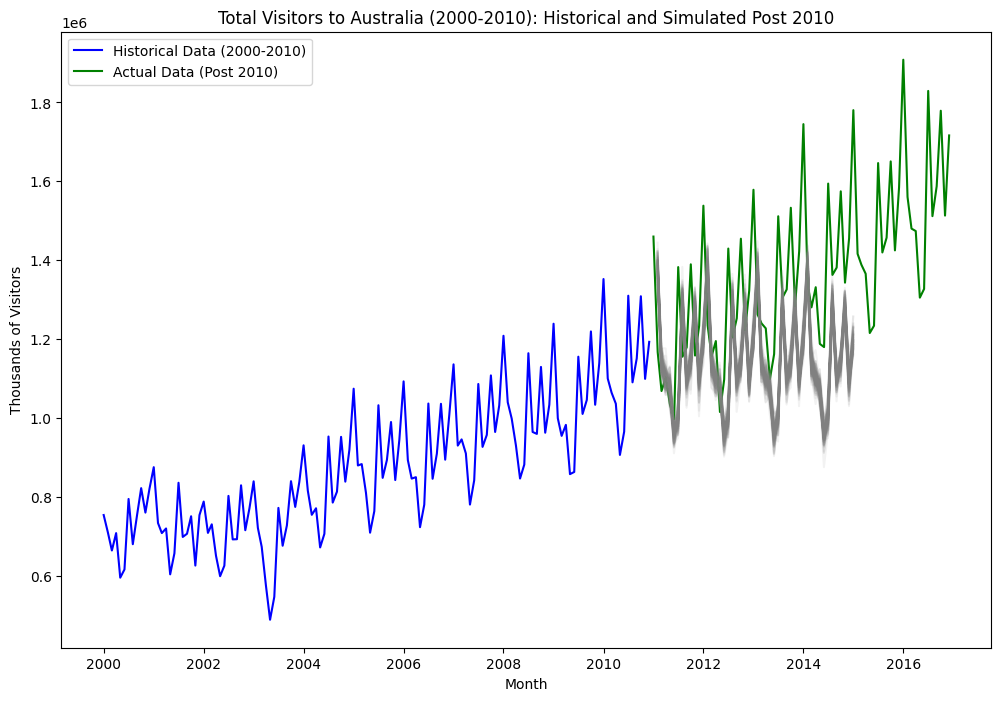

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing


austa_up_to_2010 = austa[austa['Month'] <= '2010-12-31']
fit = ExponentialSmoothing(austa_up_to_2010['Visitors'], seasonal='add', seasonal_periods=12).fit()

forecast_start_date = '2011-01-01'
forecast_steps = 48  
num_simulations = 100

forecast = fit.forecast(steps=forecast_steps)

np.random.seed(1967)
simulated_paths = pd.DataFrame()

residual_std = fit.resid.std()

for i in range(num_simulations):
    new_residuals = np.random.normal(0, residual_std, size=forecast_steps)
    simulated_forecast = forecast + new_residuals
    simulated_df = pd.DataFrame({
        'Month': pd.date_range(start=forecast_start_date, periods=forecast_steps, freq='M'),
        'Visitors': simulated_forecast,
        'Simulation': i + 1
    })
    simulated_paths = pd.concat([simulated_paths, simulated_df], ignore_index=True)


plt.figure(figsize=(12, 8))

austa_filtered = austa[(austa['Month'] >= '2000-01-01') & (austa['Month'] <= '2010-12-31')]
sns.lineplot(data=austa_filtered, x='Month', y='Visitors', label='Historical Data (2000-2010)', color='blue')
sns.lineplot(data=actual_post_2010, x='Month', y='Visitors', label='Actual Data (Post 2010)', color='green')

for i in range(1, 101):
    sim_data = simulated_paths[simulated_paths['Simulation'] == i]
    sns.lineplot(data=sim_data, x='Month', y='Visitors', color='gray', alpha=0.1)

plt.title("Total Visitors to Australia (2000-2010): Historical and Simulated Post 2010")
plt.xlabel("Month")
plt.ylabel("Thousands of Visitors")
plt.legend()
plt.show()


# B. 시계열 예측 - 통계적 예측 관점
- 시계열 예측에서는, 시간을 나타내기 위해 아래 첨자 $t$를 사용한다. 시간$t$에서의 관측값은 $y_t$로 나타낸다. 
- 우리가 관찰한 모든 정보를 $I$라 하고, $y_t$를 예측하고 싶다고 할 때,$y_t|I$는 $I$를 알고 있는 상태에서 확률변수 $y_t$라는 의미이다. 
- 이 때, 확률변수 $y_t$ 취할 수 값들의 집합과 그 확률을 $y_t|I$라 하고, 이것을 예측 분포(Forecast Distribution)이라고 한다. 
- “예측”에 대해 이야기할 때, 우리는 보통 예측 분포의 평균값을 의미하며,이를 나타내기 위해 $\hat{y}_t$을 사용한다. 이는 $y_t$가 취할 수 있는 가능한 값들의 평균을 의미한다.
- 예측값을 구하는 것은 무작위 변수가 취할 수 있는 가능한 값 범위의 중간값을 구하는 것이다.  -> 점추정(Point Estimate)값을 구하는 것이다. 
- 미래 값들의 신뢰구간(Prediction Interval) 또한 함께 표현되기도 한다. 
- 통계학에서 신뢰 구간은 모수가 어느 범위 안에 있는지를 확률적으로 보여주는 방법이다. 예를 들면, 95% 예측 구간은 95% 의 실제 미래 값이 포함되어야 하는 값의 범위가 된다.


# C. 시계열 예측 - 예측 문제 일반 설정
-  시계열 예측은 과거 히스토리에 대한 데이터인 $z_t$들을 이용해, 미래 시점의 데이터를 예측하는 것이다. 
- $z_{i,0}, z_{i,1}, \ldots, z_{i,T-1}, z_{i,T} \Rightarrow P(z_{i,T+1}, z_{i,T=1}, \ldots, z_{i,T+h})$
 - 0에서 T시점까지의 데이터를 이용하여, T+1시점에서 T+h시점 까지의 데이터를 확률적으로 추정한다는 의미이다. 
- 시계열 예측은, 최적의 의사결정을 하기 위해 시행하는 경우가 많다. 따라서 상황에서의 비용(cost)를 최소화시킬수 있는 액션을 취하는 방법을 택해야 한다. 식으로 나타내면 아래 수식과 같다.
- $\text{best action} = \arg\min_{a} E_P \left[ \text{cost}(a, z_{i,T+1}, z_{i,T=1}, \ldots, z_{i,T+h}) \right]$

### 시계열 예측의 예시 - Newsvendor Model
- 신문을 구매해서 판다고 할 때,수익을 극대화시키면서 구매해야하는 신문의 양을 계산하는 모델이다. 
- $p$ – sales price
- $c$ – purchase price
- $q$  – purchase quantity
- $𝑍$ – demand  (𝑍 ~ 𝑃 )
- 수요인 Z를 예측하는 것이 핵심이다. 
- $E[\text{profit}] = E[p \min(q, Z)] - cq \quad q^* = \arg\max_q E[p \min(q, Z)] - cq = F^{-1}\left(\frac{p-c}{p}\right)$
 - 평균 수익을 최대화하는 신문 구매량 $q$를 구하는 수식이다.



# D. 시계열 예측 - 예측 평가
### 예측 평가 메트릭
 - **점 추정(Point Estimate)을 평가하기 위한 메트릭**
   - 점추정 값은 $\hat{z}_t$를 사용한다.
   - Absolute Error: $\quad e_t = |z_t - \hat{z}_t|$
   - Mean Absolute Error: (MAE) 
       - $\quad \text{mean}(e_t) \quad (\text{예상 구간 h에 대해})$
   - Mean Absolute Percentave Error: (MAPE) 
       - $\quad \frac{1}{h} \sum_t \left|\frac{e_t}{z_t}\right|$
   - Root Mean Square Error (RMSE): $\sqrt{\text{mean}(e_t^2)}$  
   - MAE, MAPE, RMSE 값이 작을수록 좋은 예측이라고 평가한다.
 - 점 추정(Point Estimate)은 의사결정을 할 때 충분하지 않은 경우가 많다.
 - 단순히 오차를 줄이는 것이 좋은 결정이 아니라, 다양한 sample path에 대해 평균적인 cost를 minimize하는것이 좋은 결정이기 때문이다. 
 - 확률 추정 (Probailistic Forecast)을 자주 사용한다.

- **확률 추정을 평가하기 위한 메트릭**
  - P90 예측
    - P90 예측: 90%로 실제값이 예측값보다 작게 만드는 예측값. 
    - 즉, 90% 확률로 $z_t \leq \hat{z}_t^{0.9}$이 성립한다.
    - 마찬가지로 q의 확률로 실제값이 예측값보다 작게 만드는 값을 Pq라 한다.
  - 분위수 손실(Quantile loss)
     - 분위수 손실 값을 최적화하면 정확한 Pq를 구할 수 있다.
     $ e_t^q = \begin{cases} q \cdot (z_t - \hat{z}_t^q) & \text{if } z_t \geq \hat{z}_t^q \\ (1 - q) \cdot (\hat{z}_t^q - z_t) & \text{if } \hat{z}_t^q \geq z_t \end{cases} $ 
     - q = 90%이면, 0.9 분위수 예측보다 실제 값이 클 때, 0.9의 페널티를 주고, 그 반대의 경우 0.1의 페널티를 주는 수식이다.
 - 적중률(Hit Rate)/교정(Calibration)
     - 	교정(Calibration): $(\text{Percentage of } z_t \leq \hat{z}_t^q) \approx q$
     - 	실제 시계열 데이터가 5, 5, 5, 5, ...이고, P50 예측이 0, 100, 0, 100, ...이라면 calibration 관점에서는 50%를 정확히 맞추지만, 좋은 예측은 아니다. 예측의 구간이 너무 크기 때문이다.
     - 즉, 교정(Calibration)을 잘 맞추는 것으로 충분하지 않다.
  - "확률 추정의 목적은 교정(Calibration)을 맞추면서 Sharpness를 최대화하는 것이다!" [Gneiting et al., 2007]
  - Sharpness : 예측 구간의 폭
   - 예측 구간의 폭이 작을수록 Sharpness가 높다.
  - 예측의 분포(Forecast Distribution)은 실제 분포와 최대한 비슷해야한다.
  - **Continuous Ranked Probability Score (CRPS)**
     - $CRPS = \int_{0}^{1} \text{quantile loss}(q) \, dq$
     - $CRPS$를 최적화하면 sharp하고 calibrated된 예측을 할 수 있다.




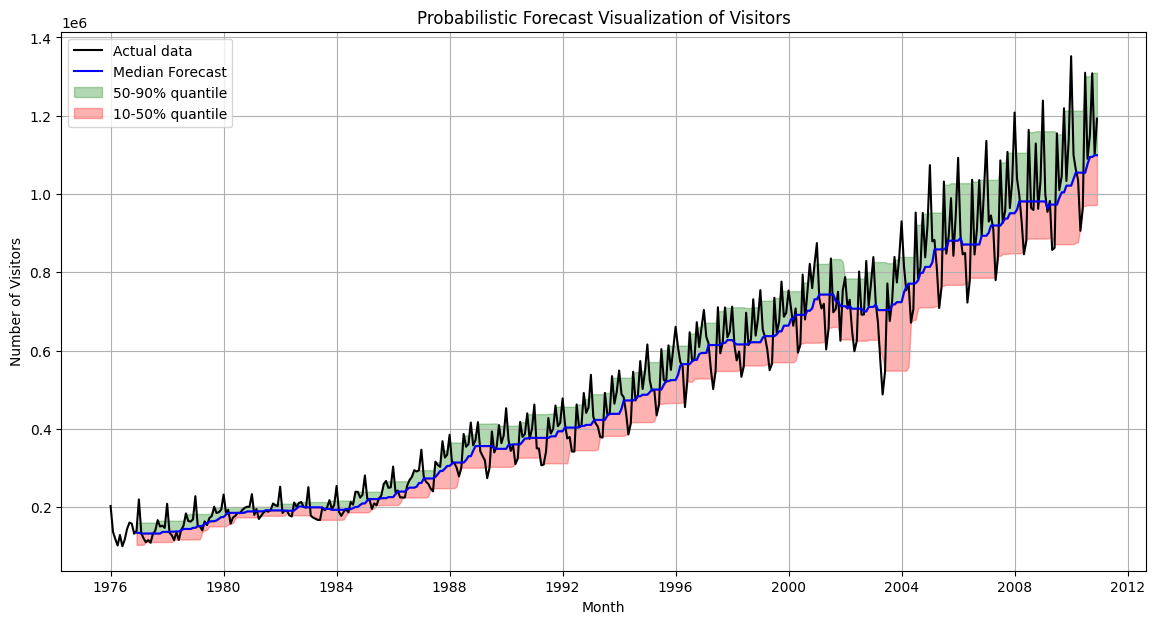

In [17]:
import matplotlib.pyplot as plt
import numpy as np


austa_up_to_2010.set_index('Month', inplace=True)
rolling_window = 12 
median_forecast = austa_up_to_2010['Visitors'].rolling(window=rolling_window).median()
p90_forecast = austa_up_to_2010['Visitors'].rolling(window=rolling_window).quantile(0.9)
p10_forecast = austa_up_to_2010['Visitors'].rolling(window=rolling_window).quantile(0.1)

plt.figure(figsize=(14, 7))
plt.plot(austa_up_to_2010.index, austa_up_to_2010['Visitors'], label='Actual data', color='black')
plt.plot(austa_up_to_2010.index, median_forecast, label='Median Forecast', color='blue')

plt.fill_between(austa_up_to_2010.index, median_forecast, p90_forecast, color='green', alpha=0.3, label='50-90% quantile')

plt.fill_between(austa_up_to_2010.index, median_forecast, p10_forecast, color='red', alpha=0.3, label='10-50% quantile')

plt.grid(True)
plt.title('Probabilistic Forecast Visualization of Visitors')
plt.xlabel('Month')
plt.ylabel('Number of Visitors')
plt.legend()

plt.show()

### 백테스팅 (Backtesting)
- 백테스팅이란, 훈련에 사용하지 않은 과거 데이터를 기반으로 예측의 성능을 평가하는 것이다.
- 테스트 데이터의 시작점에 따라 예측의 정확도가 달라질 수 있다.
- 고정된 시계열의 관측 데이터의 시작점을 늘려가며 예측 정확도 계산 후 평균을 내서 사용하면 시작 시점에 의존하지 않는 예측 정확도를 구할 수 있다.


### 예측 정확도(Accuracy)
- MAPE 기반의 다양한 정확도(measure) 점수들이 존재한다.
   - MRAE, RelMAE, MASE 등의 measure
   
- 세가지 다른 관점의 예측 정확도(Accuracy Measure)가 존재한다.
  - 모델을 훈련시키기 위한 손실함수(loss function)
  - 백테스팅에서의 예측 정확도
  - 주주들에게 보고할 예측 정확도
- 척도(metric)은 간단하고 직관적이어야 한다. 
- $\text{best action} = \arg\min_{a} E_P \left[ \text{cost}(a, z_{i,T+1}, z_{i,T=1}, \ldots, z_{i,T+h}) \right]$
    - 주어진 상황에서 비용함수(cost)를 최소화하는 행동이 가장 합리적인 행동이다.
- 예측을 하는 것이 비용함수를 최적화하는데 도움이 되느냐에 초점을 맞춰야 한다. 
- 예측이 이루어졌을 때의 downstream consequence를 이해하는 것이 중요하다. 
- 더 정확한 예측이 항상 더 나은 downstream 의사결정으로 이어지는 것은 아니다.